In [40]:
import psycopg2
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from psycopg2.extras import NamedTupleCursor
from Local_DB import DB_NAME, DB_HOST, DB_PORT, DB_USER, DB_PASSWD

plt.ioff()

In [2]:
DB_CONNECT_STRING = "dbname={0} host={1} port={2} user={3} password={4}".format(
    DB_NAME, DB_HOST, DB_PORT, DB_USER, DB_PASSWD
)
START_DATE = '2019-06-01'   # this day will be included
END_DATE   = '2019-06-30'   # and this also will be (we have dates only, not times)

PREV_START_DATE = '2019-05-01'  # start and stop dates for May's data to compare
PREV_END_DATE   = '2019-05-31'

В нашу задачу входит сравнение мая и июня, поэтому каждое CTE будет в двух вариантах: для майских пользователей и для июньских.  Варианты делаются из одного шаблона.  Ниже будут определяться дополнительные CTE.

In [3]:
# template for SQL expression: all users registered btw two dates list
USERS_CTE_TMPL = """ {0} as (
SELECT DISTINCT user_id, registration_date
    FROM case9.registration
    WHERE registration_date between '{1}' AND '{2}')
"""

JUN_USERS_CTE = USERS_CTE_TMPL.format('users_jun19', START_DATE, END_DATE)
MAY_USERS_CTE = USERS_CTE_TMPL.format('users_may19', PREV_START_DATE, PREV_END_DATE)

In [4]:
# functions
def init_connect(conn_string) -> psycopg2.extensions.cursor:
    db_conn = psycopg2.connect(conn_string, cursor_factory=NamedTupleCursor)
    cursor = None
    if db_conn:
        db_conn.set_session(readonly=True,autocommit=True)
        cursor = db_conn.cursor()
    return cursor

In [5]:
def _format_select(ctes: "list of CTEs", select: "SQL select") -> str:
    """Форматирует SQL запрос из списка CTE и выражения 'select', заданных соответственно первым
    и вторым параметрами"""
    query = ( "with " + ", ".join(ctes) + " " + select)
    if query[-1] != ';':
        query = query + ';'
    return query

In [6]:
def simple_query(cursor: "PsycoPg2 DB cursor", 
                 ctes: "list of CTEs", 
                 select: "select sql query as a string") -> str:
    """Запрос, после которого из базы возвращается одна строка, м.б. с несколькими полями.
    Параметры: 1) курсор базы, 2) SQL запрос
    Запрос должен возвращать одну строку (или возвращается первая строка)
    Возвращает: результат запроса
    Возможен возврат None.
    """
    query = _format_select(ctes, select)
    # print("*DBG* simple_query will execute:\n" + query)
    cursor.execute(query)
    first_line = cursor.fetchone()
    __ = cursor.fetchall()  # discard remaining lines
    return first_line

In [7]:
def multiline_query(cursor: "Database cursor", ctes: "list of CTEs", 
                    select: "select sql query as a string") -> list:
    """Запрос, возвращающий из базы много данных.
    Параметры: 1) Курсор PsycoPg2, 3) запрос SQL в виде строки.
    Возвращает: список Named Tuple-ов -- результат запроса. Если результатов
    нет, будет возвращён None."""
    query = _format_select(ctes, select)
    # print("*DBG* multiline_query will execute:\n" + query)
    cursor.execute(query)
    return cursor.fetchall()

In [8]:
cursor = init_connect(DB_CONNECT_STRING)

## Повторяем то, что написано в учебнике

In [9]:
users_count =  simple_query(cursor, [JUN_USERS_CTE],
                          'select count(user_id) from users_jun19;')
print(users_count)

Record(count=100423)


Использование DISTINCT под count() ничего не меняет, что означает, что дважды зарегистрированных пользователей с одним ID не бывает.  Запомним на будущее.

In [10]:
cursor = init_connect(DB_CONNECT_STRING)
users_count =  multiline_query(cursor, [JUN_USERS_CTE],
                          'select * from users_jun19 limit 3;')
print(users_count)

[Record(user_id='000032c7-0fc4-4382-bdc9-52891fe79077', registration_date=datetime.date(2019, 6, 4)), Record(user_id='0000ca0e-154f-41e7-a391-0e5a2fef11b4', registration_date=datetime.date(2019, 6, 8)), Record(user_id='00018971-c30b-4898-8d0d-8e6f43108ec8', registration_date=datetime.date(2019, 6, 16))]


In [11]:
COHORTS_TMPL = """{0} as (
    SELECT 
        ac.activity_date,
        u.registration_date,
        count(distinct(user_id)) as active_users_count
    FROM  case9.user_activity ac
    JOIN  {1} as u
    USING (user_id)
    GROUP BY ac.activity_date, u.registration_date
)"""

JUN_COHORTS_CTE = COHORTS_TMPL.format('cohorts_jun19', 'users_jun19')
MAY_COHORTS_CTE = COHORTS_TMPL.format('cohorts_may19', 'users_may19')

In [12]:
multiline_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE], "SELECT * from cohorts_jun19 limit 3;")

[Record(activity_date=datetime.date(2019, 6, 1), registration_date=datetime.date(2019, 6, 1), active_users_count=1651),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 1), active_users_count=1429),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 2), active_users_count=1933)]

Какое количество активных пользователей было зафиксировано на 10 июня 2019 для пользователей, зарегистрировавшихся 1 июня 2019 г.?

In [13]:
simple_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE], 
         """SELECT active_users_count from cohorts_jun19 
             WHERE registration_date='2019-06-01' 
                 AND activity_date='2019-06-10';""")[0]

483

### Определение Retention Rate

Для определения retention rate предлагается объединять датафреймы в памяти. У меня ещё никаких датафреймов нет, и вообще джойнить таблицы - это работа сервера БД.  Ему нужно только всё правильно объяснить. Для начала сделаю CTE для таблицы "дата регистрации - количество зарегистрированных пользователей".

In [17]:
USERS_BY_REGDATE_TMPL = """{0} as (
    SELECT registration_date, count(user_id) as registered_users_count
    FROM {1}
    GROUP BY registration_date
    ORDER BY registration_date
)"""

JUN_USERS_BY_REGDATE_CTE = USERS_BY_REGDATE_TMPL.format("users_by_registration_date_jun19", "users_jun19")
MAY_USERS_BY_REGDATE_CTE = USERS_BY_REGDATE_TMPL.format("users_by_registration_date_may19", "users_may19")

Проверю, что выдаются осмысленные результаты:

In [18]:
multiline_query(cursor, [JUN_USERS_CTE, JUN_USERS_BY_REGDATE_CTE], 
                "SELECT * from users_by_registration_date_jun19 limit 3;")

[Record(registration_date=datetime.date(2019, 6, 1), registered_users_count=4833),
 Record(registration_date=datetime.date(2019, 6, 2), registered_users_count=5255),
 Record(registration_date=datetime.date(2019, 6, 3), registered_users_count=4193)]

И напишу выражение для объединения таблиц.  Сразу посчитаю retention_rate и lifetime (кол-во дней с момента регистрации).

In [19]:
MONTH_RETENTION_CTE = """{0} as (
    SELECT 
        activity_date, 
        registration_date, 
        registered_users_count, 
        active_users_count,
        active_users_count*1.0 / registered_users_count as retention_rate,
        activity_date - registration_date as lifetime
    FROM {1}
    JOIN {2}
    USING (registration_date) 
)"""

JUN_RETENTION_CTE = MONTH_RETENTION_CTE.format('retention_jun19', 'cohorts_jun19', 
                                               'users_by_registration_date_jun19')
MAY_RETENTION_CTE = MONTH_RETENTION_CTE.format('retention_may19', 'cohorts_may19', 
                                               'users_by_registration_date_may19')

In [21]:
multiline_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE], 
                "SELECT * from retention_jun19 LIMIT 3;")

[Record(activity_date=datetime.date(2019, 6, 1), registration_date=datetime.date(2019, 6, 1), registered_users_count=4833, active_users_count=1651, retention_rate=Decimal('0.34160976619077177736'), lifetime=0),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 1), registered_users_count=4833, active_users_count=1429, retention_rate=Decimal('0.29567556383198841299'), lifetime=1),
 Record(activity_date=datetime.date(2019, 6, 2), registration_date=datetime.date(2019, 6, 2), registered_users_count=5255, active_users_count=1933, retention_rate=Decimal('0.36784015223596574691'), lifetime=0)]

Какой Retention Rate наблюдается на 18 июня 2019 г. у пользователей когорты, зарегистрировавшихся 3 июня 2019 г.? Ответ дайте в процентах с точностью до двух знаков после точки-разделителя.

In [22]:
simple_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE], 
                """SELECT round(retention_rate*100,2) AS retention_pct 
                FROM retention_jun19 
                WHERE activity_date='2019-06-18' AND registration_date='2019-06-03';
                """)[0]

Decimal('7.68')

Теперь сформируем сводную таблицу.

Агрегировать особо нечего, но в конечном итоге нужно получить таблицу, где строки -- дата регистрации, а колонки - lifetime. Исследумый месяц -- июнь, поэтому получится 30 строк (1-30 июня).  Сколько будет колонок, пока неизвестно, но узнать стоит.  Спрашиваю базу:

In [23]:
simple_query(cursor, [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE], 
                "SELECT max(lifetime) as max_lt from retention_jun19")

Record(max_lt=30)

Матрица 30×31 -- это меньше 1000 значений, считываю данные в датафрейм:

In [25]:
retention_df = pd.DataFrame(multiline_query(cursor, 
        [JUN_USERS_CTE, JUN_COHORTS_CTE, JUN_USERS_BY_REGDATE_CTE, JUN_RETENTION_CTE],
        """SELECT registration_date, lifetime, retention_rate 
           FROM retention_jun19 
           ORDER BY registration_date, lifetime 
        """))
print(retention_df.head(3))
print(retention_df.info())

  registration_date  lifetime          retention_rate
0        2019-06-01         0  0.34160976619077177736
1        2019-06-01         1  0.29567556383198841299
2        2019-06-01         2  0.21125594868611628388
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
registration_date    930 non-null object
lifetime             930 non-null int64
retention_rate       930 non-null object
dtypes: int64(1), object(2)
memory usage: 21.9+ KB
None


Получили таблицу в "длинном" формате, да ещё значения даты и `retention_rate` строковые (`object`). Для того, чтобы повторить изображённый в учебнике heatmap, нужно преобразовать данные и перевести таблицу в "широкий" формат.

In [26]:
retention_df['registration_date'] = pd.to_datetime(retention_df.registration_date)
retention_df['retention_rate'] = retention_df.retention_rate.astype('float')
retention_df = retention_df.set_index(['registration_date', 'lifetime'])
retention_pvt = retention_df.unstack('lifetime')

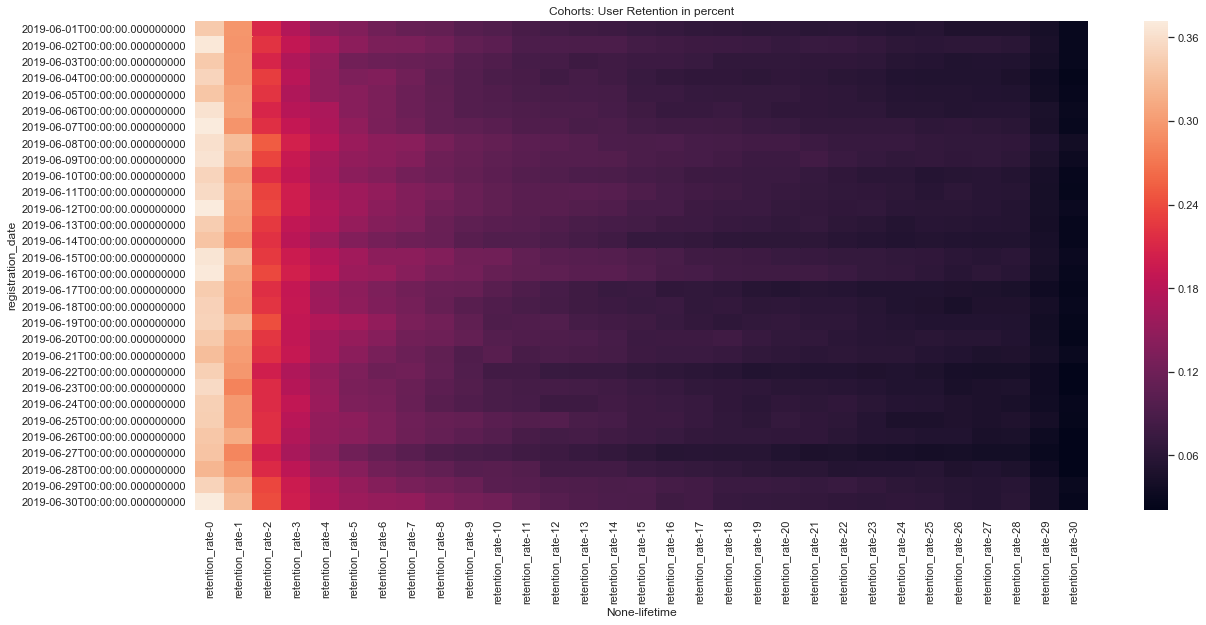

In [30]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention in percent')
sns.heatmap(retention_pvt, annot=False, fmt='.0%', linewidths=0);
plt.show()


На мой вкус, цифры на heatmap-е только мешают восприятию, но это как кому нравится. Чтобы получить срез на определённый день, можно воспользоваться любым из датафреймов: `retention_df` или `retention_pvt`.

Из задания:
> Что можно сказать об изменении Retention Rate на 0-й день для дневных когорт июня 2019 г.?

In [ ]:
retention_df.head(5)

Наш датафрейм с двухуровневым индексом, нужный массив данных из него получается методом `.xs`:

In [ ]:
day0_df = retention_df.xs(0, level='lifetime')
__ = day0_df.plot(kind='bar', figsize=(20,5))

Можно сказать, что `retention_rate` когорт на нулевой день колеблется около значения 0.35, но определённого тренда нет.

Аналогично на 7-й день:

> Что можно сказать об измнении Retention Rate на 7-й день в когорте зарегистрировашихся 30 июня относительно когорты 1 июня?

In [ ]:
__ = retention_df.xs(7, level='lifetime').plot(kind='bar', figsize=(20,5))

Можно сказать, что на 7-й день в когорте 30 июня retention rate увеличился по сравнению с 1 июля, хотя определённого линейного тренда в течение месяца не просматривается.  Разброс по дням также вырос.

> Рассчитайте для каждого дня lifetime усредненный Retention Rate по всем когортам июня 2019 г.
> Постройте график изменения среднего Retention Rate в июне 2019 г. в зависимости от времени жизни пользователя.
> Опишите, какие выводы можно сделать на основе графика изменения Retention Rate.

На мой вкус, интереснее показать не только среднее, но и разброс.  Да и среднее слишком чувствительно к выбросам.  Построю боксплоты по каждому дню лайфтайма, это даёт лучшее представление, чем просто среднее.

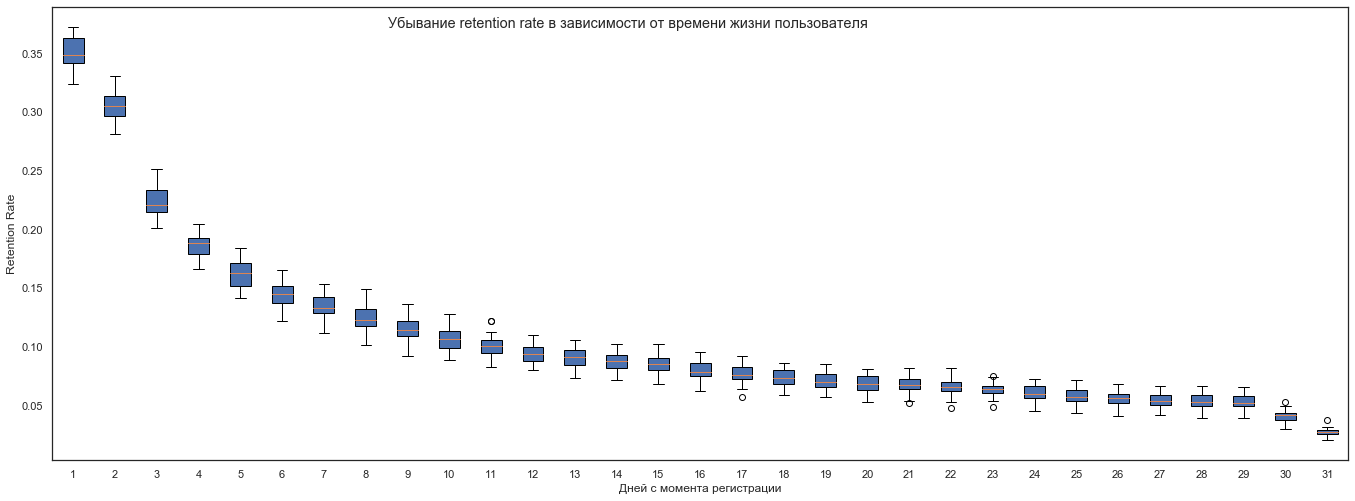

In [35]:
jun_ret_bp_list = [ retention_df.xs(lt, level='lifetime')['retention_rate'] for lt in range(0,31) ]
fig = plt.figure(figsize=(20,7))
ax = fig.add_axes((0.1, 0.1, 0.9, 0.9))
ax.set_xlabel('Дней с момента регистрации')
ax.set_ylabel('Retention Rate')
fig.suptitle('Убывание retention rate в зависимости от времени жизни пользователя')
__ = ax.boxplot(jun_ret_bp_list, notch=False, patch_artist=True)
plt.show()

График любопытный. Видно, что данные неплохо ложатся на линию обратной пропорциональности количеству дней с момента регистрации, и кривая вроде бы выходит на асимптоту, параллельную оси X, но только до 29-го дня.  Дальше следует резкий провал retention rate на 30-31 дне.

Но просто значения — это малоинтересно, гораздо лучше смотреть динамику. Для этого нужно получить датафрейм, аналогичный данным июня 2019, только за май.  Тогда, наложив два графика, мы увидим разницу.

In [36]:
may_retention_df = pd.DataFrame(multiline_query(cursor, 
        [MAY_USERS_CTE, MAY_COHORTS_CTE, MAY_USERS_BY_REGDATE_CTE, MAY_RETENTION_CTE],
        """SELECT registration_date, lifetime, retention_rate 
           FROM retention_may19 
           ORDER BY registration_date, lifetime 
        """))
may_retention_df['registration_date'] = pd.to_datetime(may_retention_df.registration_date)
may_retention_df['retention_rate'] = may_retention_df.retention_rate.astype('float')
may_retention_df = may_retention_df.set_index(['registration_date', 'lifetime'])
print(may_retention_df.head(3))
print(may_retention_df.info())

                            retention_rate
registration_date lifetime                
2019-05-01        0               0.397483
                  1               0.329343
                  2               0.251228
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 961 entries, (2019-05-01 00:00:00, 0) to (2019-05-31 00:00:00, 30)
Data columns (total 1 columns):
retention_rate    961 non-null float64
dtypes: float64(1)
memory usage: 10.1 KB
None


Сейчас мы можем вывести два графика в одних координатах.  Список `jun_ret_bp_list` у нас остался с предыдущего построения, создам новый, с майскими данными (`may_ret_bp_list`).


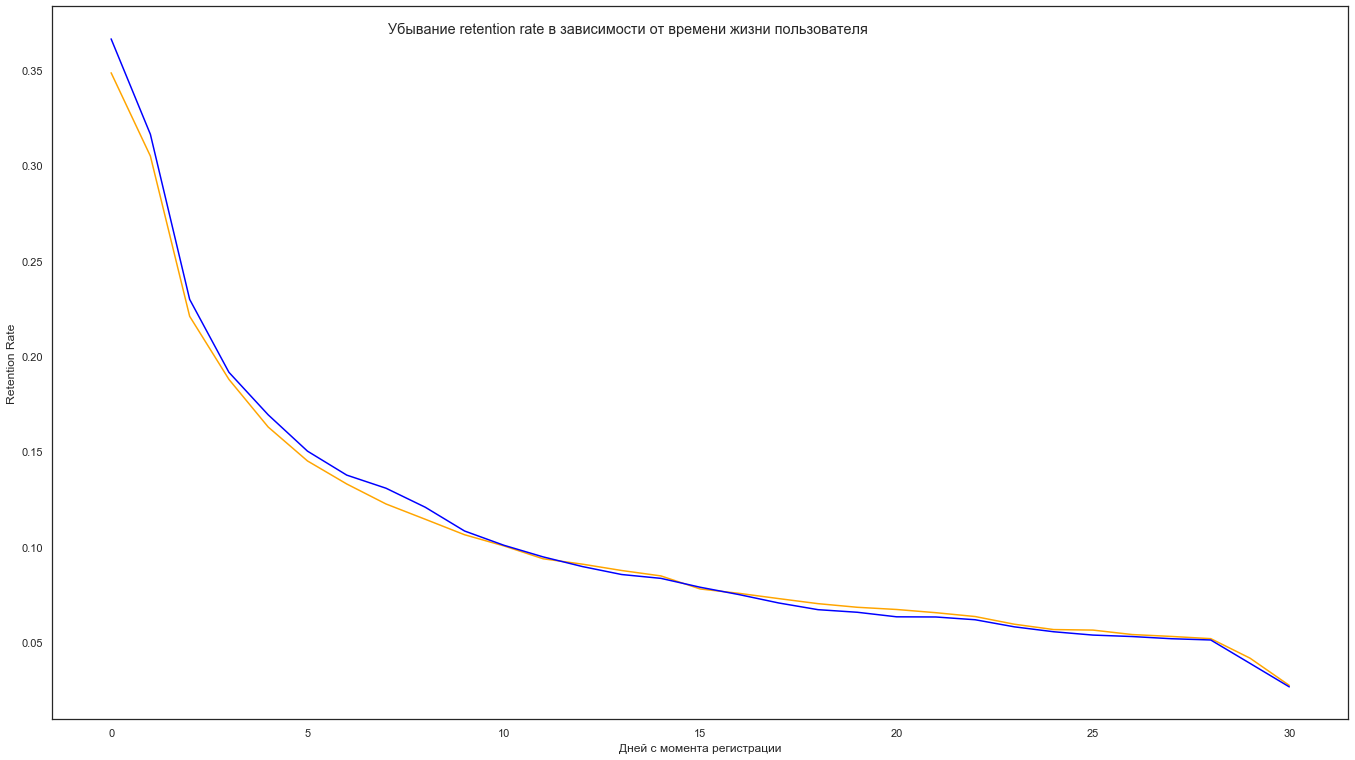

In [47]:
jun_ret_median_list = [ retention_df.xs(lt, level='lifetime')['retention_rate'].median() for lt in range(0,31) ]
may_ret_median_list = [ may_retention_df.xs(lt, level='lifetime')['retention_rate'].median() for lt in range(0,31) ]

fig = plt.figure(figsize=(20,11))
ax = fig.add_axes((0.1, 0.1, 0.9, 0.9))
ax.set_xlabel('Дней с момента регистрации')
ax.set_ylabel('Retention Rate')
fig.suptitle('Убывание retention rate в зависимости от времени жизни пользователя')
__ = ax.plot(jun_ret_median_list, color='orange')
__ = ax.plot(may_ret_median_list, color='blue')
# XXX Но я хочу боксплоты, а не только медианы!
plt.show()

links:
https://matplotlib.org/devel/MEP/MEP28.html?highlight=multiple%20boxplots
https://matplotlib.org/devel/MEP/MEP28.html?highlight=multiple%20boxplots#mep28-remove-complexity-from-axes-boxplot
https://matplotlib.org/tutorials/introductory/customizing.html


### Расчёт ARPU